In [1]:
import sys
sys.path.append(".")

In [2]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pylab as plt
from pathlib import Path
from tensorflow.keras import layers

#from PlayingCardsGenerator import CardsDataGenerator
import datetime

In [3]:
model_name_it = "Outputs/Efficient_net_B0_it_52.h5"

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [6]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [7]:
def scheduler(epoch, lr):
    if epoch%30 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [61]:
%load_ext tensorboard

In [10]:
log_dir = "Outputs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "rotation_range":90,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "vertical_flip":True}

In [12]:
generator = ImageDataGenerator(**gen_params, validation_split=0.2,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [13]:
bs = 16 # batch size

In [14]:
path = Path("dataset/")

In [15]:
img_height = 224
img_width = 224

In [16]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [17]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    shuffle = True,
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as training data

Found 24952 images belonging to 52 classes.


In [18]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    seed=42,
    classes=classes_names) # set as validation data

Found 6206 images belonging to 52 classes.


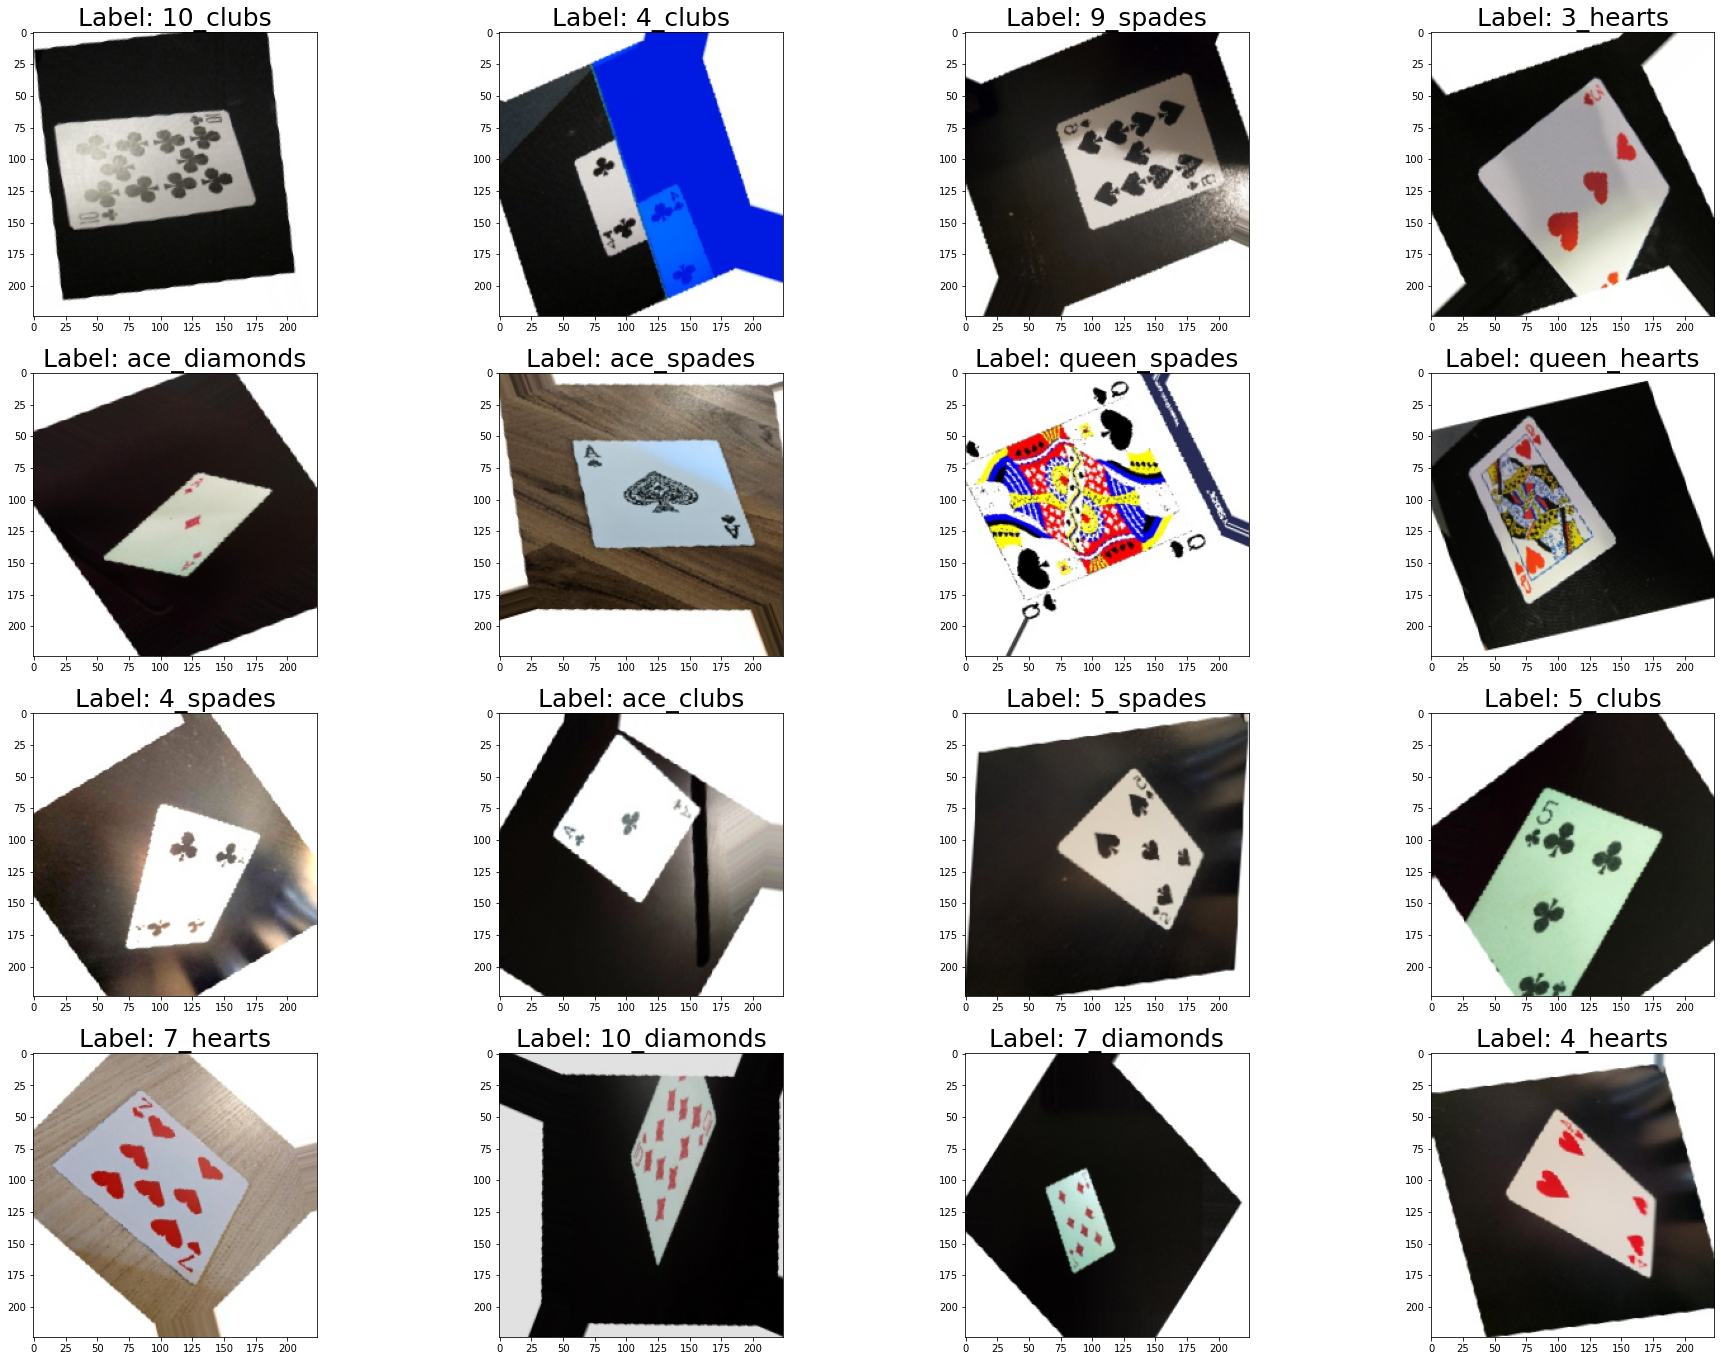

In [19]:
#Exploratory data analysis
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [20]:
# Defining the model

trainable_flag = True
include_top_flag = False
weigths_value = 'imagenet'

if trainable_flag:
    include_top_flag = True
    weigths_value = None
else:
    include_top_flag = False
    weigths_value = 'imagenet'    


In [21]:
print(weigths_value)
print(include_top_flag)
print(trainable_flag)

base_model = tf.keras.applications.EfficientNetB0(
    weights=weigths_value, 
    include_top=include_top_flag,
    classes=len(classes_names))

None
True
True


In [35]:
inputs = layers.Input(shape=(img_height,img_width,3))
outputs = tf.keras.applications.EfficientNetB0(include_top=include_top_flag, weights=weigths_value,drop_connect_rate=0.3, classes=len(classes_names))(inputs)
model = tf.keras.Model( inputs,  outputs)

In [36]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________
None


In [63]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), #
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [142]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [143]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 1e-4)

In [147]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

Epoch 1/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9489
Epoch 1: val_loss did not improve from 0.28560
1560/1560 [==============================] - 399s 255ms/step - loss: 0.1556 - accuracy: 0.9489 - val_loss: 0.3940 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 2/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9505
Epoch 2: val_loss did not improve from 0.28560
1560/1560 [==============================] - 396s 254ms/step - loss: 0.1490 - accuracy: 0.9505 - val_loss: 0.3058 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 3/1000
1560/1560 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9523
Epoch 3: val_loss improved from 0.28560 to 0.20209, saving model to Outputs\Efficient_net_B0_it_52.h5
1560/1560 [==============================] - 394s 253ms/step - loss: 0.1473 - accuracy: 0.9523 - val_loss: 0.2021 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 4/1000
1560/1560 [==============================

In [279]:
model.save('final_it_EfficientNetB0_52_9_percent.h5')
#np.save('efficientNetB0_history_96.npy',history_it.history)


In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [285]:
model = tf.keras.models.load_model(model_name_it)
model.summary()
#model.get_weights()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 52)               4116183   
                                                                 
Total params: 4,116,183
Trainable params: 4,074,160
Non-trainable params: 42,023
_________________________________________________________________


In [283]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.5e-4)

In [284]:
history_ft = model.fit(train_generator, epochs=10, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [monitor_it,early_stop,lr_schedule,tensorboard_callback])

Epoch 1/10
1560/1560 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9972
Epoch 1: val_loss did not improve from 0.09243
1560/1560 [==============================] - 403s 257ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.1107 - val_accuracy: 0.9797 - lr: 5.0000e-05
Epoch 2/10
 117/1560 [=>............................] - ETA: 5:54 - loss: 0.0085 - accuracy: 0.9963

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir 'Outputs/logs/fit'

In [ ]:
##!jupyter nbconvert --to script train-talc.ipynb

[NbConvertApp] Converting notebook train-talc.ipynb to script
[NbConvertApp] Writing 5159 bytes to train-talc.py


In [148]:
test_generator = generator.flow_from_directory(
    directory = 'dataset_test',
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    shuffle=False,
    subset='validation',
    interpolation="nearest",
    classes=classes_names) # set as validation data
filenames = test_generator.filenames
nb_samples = len(filenames)

Found 1542 images belonging to 52 classes.


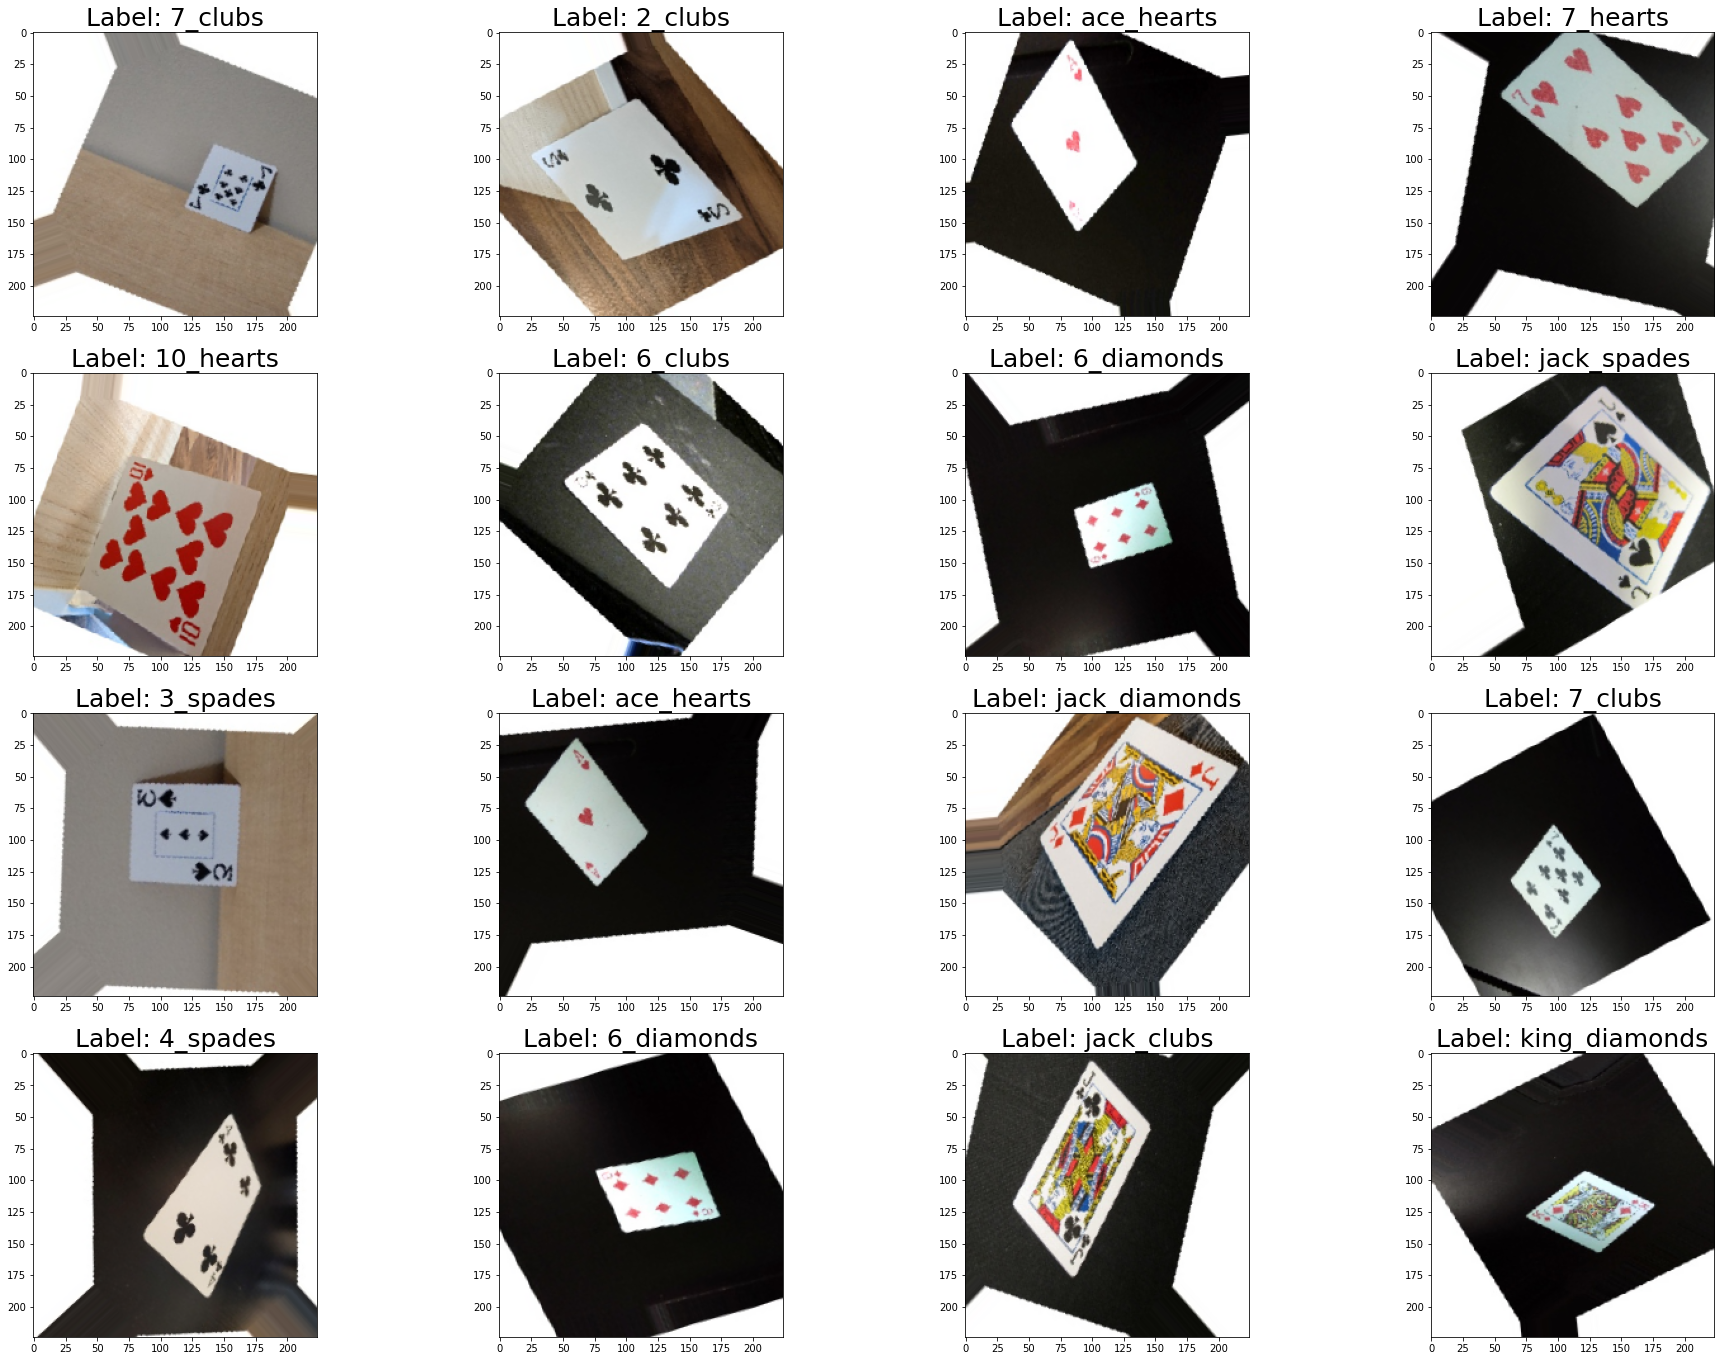

In [149]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_generator.__getitem__(0)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [267]:
predict = model.predict(test_generator, verbose = 1)


97/97 [==============================] - 50s 511ms/step


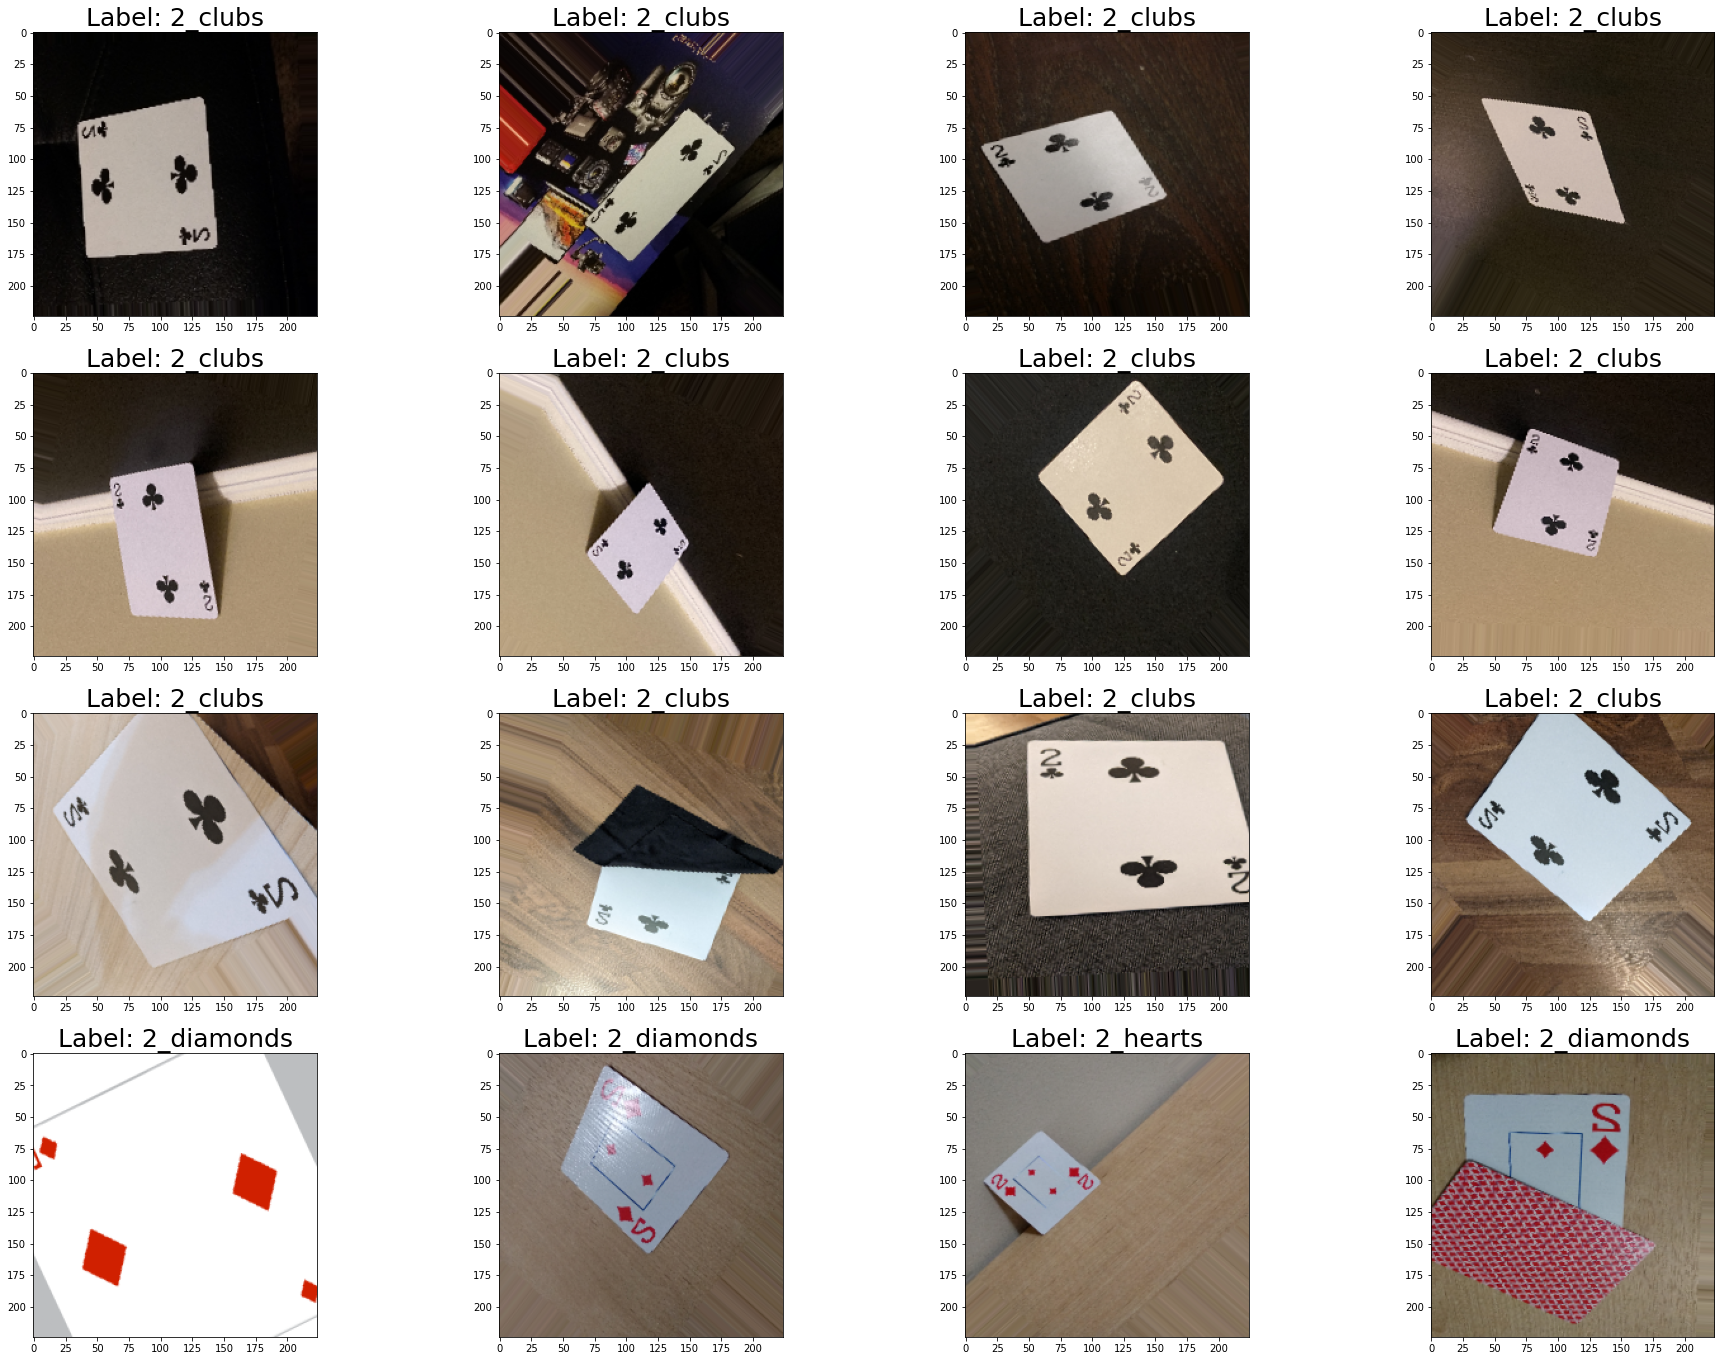

In [274]:
plt.figure(figsize = (32,24))
batch_num = 1
Xbatch,Ybatch = test_generator.__getitem__(batch_num)

for ii in range(int(bs)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(predict[ii +(batch_num*bs)].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()


In [275]:
predict1= model.evaluate(test_generator, verbose = 1)


97/97 [==============================] - 49s 506ms/step - loss: 0.1700 - accuracy: 0.9643


In [264]:
import pandas as pd
#
pred_num  = np.max(predict,axis = 1)
pred_idx = (np.argmax(predict,axis = 1)).astype(int).transpose()
pred_class = [classes_names[i] for i in pred_idx]
df = pd.DataFrame(data=pred_idx,columns= ['idx'])
df['pred_class'] = pred_num
df['pred_num'] = pred_class
df['file_name'] = filenames

In [265]:
df.head(50)

idx  pred_class    pred_num                      file_name
0     0    0.999894     2_clubs                 2_clubs\2C.png
1     0    0.978875     2_clubs                2_clubs\C21.jpg
2     0    0.999956     2_clubs               2_clubs\C210.jpg
3     0    0.829031     2_clubs                2_clubs\C22.jpg
4     0    0.996488     2_clubs                2_clubs\C25.jpg
5     0    0.999103     2_clubs                2_clubs\C26.jpg
6    40    0.980429  jack_clubs                2_clubs\C27.jpg
7     0    0.992966     2_clubs                2_clubs\C28.jpg
8     4    0.992375     3_clubs                2_clubs\C29.png
9    36    0.617907   ace_clubs      2_clubs\bg_ftdestetcw.jpg
10    0    0.999894     2_clubs      2_clubs\bg_grvcjmrgxa.jpg
11    0    0.999981     2_clubs      2_clubs\bg_hfivvzchto.jpg
12    0    0.978554     2_clubs      2_clubs\bg_hfjonkrbxf.jpg
13    0    0.981416     2_clubs      2_clubs\bg_hqgambwsox.jpg
14    0    0.999962     2_clubs      2_clubs\bg_rttydbakaf.jpg
15    0    0.999935     2_clubs     2_clubs\cards-[C2]-001.jpg
16    0    0.999831     2_clubs     2_clubs\cards-[C2]-002.jpg
17    0    0.999928     2_clubs     2_clubs\cards-[C2]-003.jpg
18    0    0.999880     2_clubs     2_clubs\cards-[C2]-004.jpg
19    0    0.999989     2_clubs      2_clubs\db_brtxueydhg.jpg
20    0    0.999998     2_clubs      2_clubs\db_ghwpggjpvx.jpg
21    0    0.991191     2_clubs      2_clubs\db_gzgkbgghew.jpg
22    0    1.000000     2_clubs      2_clubs\db_kynlszrvtm.jpg
23    0    0.999990     2_clubs      2_clubs\db_yxncbessuc.jpg
24    0    0.999999     2_clubs      2_clubs\jf_bfyuabnrhu.jpg
25    0    0.998911     2_clubs      2_clubs\jf_dhqkuqwngj.jpg
26    0    1.000000     2_clubs      2_clubs\jf_flxuunyxhw.jpg
27    0    0.999878     2_clubs      2_clubs\jf_itnrbhycke.jpg
28    1    0.999995  2_diamonds              2_diamonds\2D.png
29    1    0.999831  2_diamonds   2_diamonds\bg_bhztvcsfcz.jpg
30    2    0.768956    2_hearts   2_diamonds\bg_fthxgjxfzw.jpg
31    1    0.999996  2_diamonds   2_diamonds\bg_glumutekzl.jpg
32    1    1.000000  2_diamonds   2_diamonds\bg_hfxiubbvbp.jpg
33    1    0.999986  2_diamonds   2_diamonds\bg_sijlxpqisj.jpg
34    1    0.999875  2_diamonds   2_diamonds\bg_wjuzrhahcw.jpg
35    1    0.999958  2_diamonds  2_diamonds\cards-[D2]-001.jpg
36    1    0.999677  2_diamonds  2_diamonds\cards-[D2]-002.jpg
37    2    0.974534    2_hearts  2_diamonds\cards-[D2]-003.jpg
38    2    0.990751    2_hearts  2_diamonds\cards-[D2]-004.jpg
39   38    0.995482  ace_hearts             2_diamonds\d21.png
40    1    0.905107  2_diamonds            2_diamonds\d210.jpg
41    1    1.000000  2_diamonds             2_diamonds\d22.jpg
42    1    0.999997  2_diamonds             2_diamonds\d23.jpg
43    2    0.737065    2_hearts             2_diamonds\d24.jpg
44    1    0.998260  2_diamonds             2_diamonds\d25.jpg
45    1    1.000000  2_diamonds             2_diamonds\d26.jpg
46    1    0.999995  2_diamonds             2_diamonds\d27.jpg
47    1    0.997476  2_diamonds             2_diamonds\d28.jpg
48    1    0.594521  2_diamonds             2_diamonds\d29.jpg
49    1    0.999854  2_diamonds   2_diamonds\db_atdjuruncq.jpg

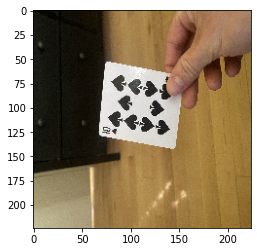

In [299]:
from keras.preprocessing import image
img_path  = "dataset_new_test/3.jpg"
img = image.load_img(img_path, target_size=(img_width, img_height))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])


In [300]:
pred = model.predict(images, batch_size=10, verbose =1)


1/1 [==============================] - 0s 17ms/step


In [301]:
print(classes_names[np.argmax(pred)])

10_spades


In [141]:
pred[0][np.argmax(pred)]

0.9711901